# 版权声明

版权 © 2023 斯坦福大厨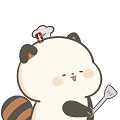，华中科技大学微纳材料设计与制造研究中心的科研工作者。

恭喜您已经发现了这份神奇的计算材料学课件！这份课件是我在熬夜吃掉不计其数的披萨和咖啡后创作出来的，配套的教材是由单斌、陈征征、陈蓉合著的《计算材料学-从算法原理到代码实现》。学习资料合集您可以在这个网址找到：[www.materialssimulation.com/book](www.materialssimulation.com/book)。希望它能帮您在计算材料学的道路上摔得不那么痛。

就像您尊重那些一边烘焙披萨一边写代码的大厨一样，当您使用这份课件时，请：

- 记得告诉大家这份课件是斯坦福大厨写的，并且他在华中科技大学微纳中心工作
- 别用它去赚大钱，这个课件是用来学习的，不是用来买披萨的
- 保持开放共享的精神

如果你有关于计算材料学的想法，或者你只是想和我讨论最好吃的披萨口味，欢迎通过邮件 bshan@mail.hust.edu.cn 联系我。
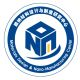

## 1. 一维谐振子运动方程

在这个notebook里，我们将用verlet算法对于一维谐振子的运动进行积分。由于一维谐振子有解析解，所以我们可以将数值积分的结果与解析形式相比对，从而对误差积累，算法稳定性等有一个直观的认识。一维谐振子的解析解如下：

1. 位置:

   $x(t) = x_0 \cos(wt) + \frac{v_0}{w} \sin(wt)$

2. 速度:

   $v(t) = -x_0 w \sin(wt) + v_0 \cos(wt)$

where,
$w = \sqrt{\frac{k}{m}}$


我们首先定义一个HarmonicOscillator的类，用于描述谐振子：

In [ ]:
import numpy as np

class HarmonicOscillator:
    def __init__(self, k, m):
        self.k = k
        self.m = m

    def acceleration(self, x):
        return -self.k * x / self.m

    def analytical_solution(self, x0, v0, t):
        """
        Calculate the analytical solution for the 1D harmonic oscillator.

        Parameters:
        x0 : float
            Initial position.
        v0 : float
            Initial velocity.
        t : float
            Time at which to calculate the position and velocity.

        Returns:
        x : float
            Position at time t.
        v : float
            Velocity at time t.
        """
        w = np.sqrt(self.k / self.m)  # angular frequency
        x = x0 * np.cos(w*t) + v0/w * np.sin(w*t)
        v = -x0 * w * np.sin(w*t) + v0 * np.cos(w*t)
        return x, v


我们可以用这样的方法来创建一个HarmonicOscillator实例，它的acceleration函数会告诉你谐振子处在位置x处的加速度

In [ ]:
# Set up the system
k = 1.0  # spring constant
m = 1.0  # mass
oscillator = HarmonicOscillator(k, m)
oscillator.acceleration(1.0)

-1.0

## 2. Verlet积分器

Position Verlet算法（也被称为Verlet积分）是一种在计算物理学中常用于解决牛顿运动方程的数值积分算法。它由法国物理学家Loup Verlet在1960年代提出，用于模拟分子动力学系统。

基本的Verlet积分算法使用当前和前一个时间步长的位置信息来计算下一个时间步长的位置，同时保证能量守恒。这使得它在模拟许多物理系统，尤其是分子动力学模拟中非常实用，因为这种模拟通常需要长时间保持精度。接下来我们将Verlet积分算法封装在VerletIntegrator类里，位置verlet算法的时间更新步如下：

$$r(t+\Delta t)=2r(t)-r(t-\Delta t)+a\Delta t^2+O(\Delta t^4)$$

$$v(t)=\frac{r(t+\Delta t)-r(t-\Delta t)}{2\Delta t}+O(\Delta t^2)$$

特别要注意的是，Verlet不是一个自启动的算法，所以第一步的时候，我们需要根据初始的速度，反推前一步的位置。只有同时有当前步和前一步的位置信息，Verlet算法才能够更新迭代获得下一步的位置信息。其基本的算法过程如下图所示：

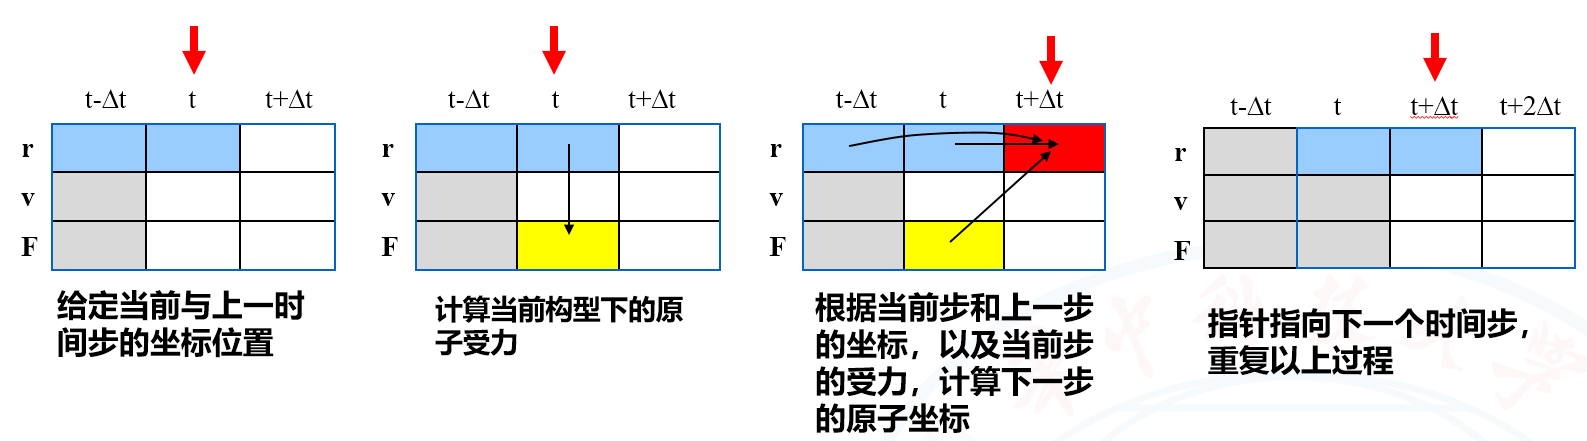

In [ ]:
class VerletIntegrator:
    def __init__(self, dt):
        self.dt = dt
        self.previous_x = None
        self.next_x = None

    def step(self, system, x, v0=None):
        '''
        Perform verlet integration on a system, stores x as previous_x and returns the new_x

        Args:
          system (class): simulation system class, should provide acceleration() method
          x (float): current position
          v0 (float): initial velocity

        Returns:
          float: the position at the next time step

        '''
        if self.previous_x is None:
            # On the first step, we can't do a full Verlet update because we
            # don't have a previous_x. Instead, we estimate previous_x using a
            # first-order Taylor expansion, taking into account initial velocity
            self.previous_x = x - v0*self.dt + 0.5*system.acceleration(x) * self.dt ** 2

        # Calculate new position using Verlet algorithm
        a = system.acceleration(x)
        new_x = 2*x - self.previous_x + a * self.dt ** 2

        # Calculate the velocity for the current position
        if self.previous_x is not None:
          current_v = (new_x - self.previous_x) / (2*self.dt)
        else:
          current_v = v0

        # Update previous_x for the next step
        self.previous_x = x

        return new_x, current_v

## 3. 用Verlet积分方法求解一维谐振子运动

我们首先定义一个用于可视化轨迹的plot_results函数

In [ ]:
import matplotlib.pyplot as plt

def plot_results(times, positions, velocities):
    """
    Plot the time evolution of position and phase space trajectory.

    This function generates two subplots: one showing the position as a function
    of time, and one showing the phase space trajectory (velocity vs. position).

    Parameters:
    times : list of float
        List of times at which the position and velocity were recorded.
    positions : list of float
        List of positions of the harmonic oscillator at the corresponding times.
    velocities : list of float
        List of velocities of the harmonic oscillator at the corresponding times.

    Returns:
    None
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(times, positions)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title('Time Evolution of Position')

    ax2.plot(positions, velocities)
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Velocity')
    ax2.set_title('Phase Space Trajectory')

    plt.tight_layout()
    plt.show()


接下来我们用dt=0.01的步长进行1000步的Verlet积分运算

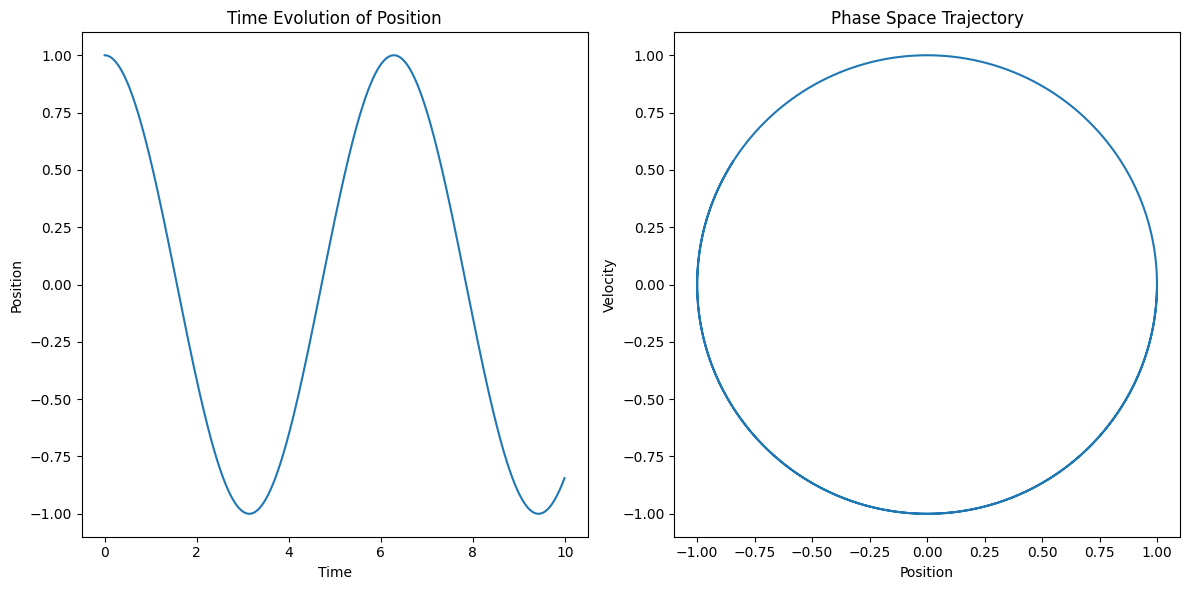

In [ ]:
import math

def main():
    # Set up the system
    k = 1.0  # spring constant
    m = 1.0  # mass
    oscillator = HarmonicOscillator(k, m)

    # Set up the integrator
    dt = 0.01  # time step
    integrator = VerletIntegrator(dt)

    # Initial conditions
    x = 1.0  # initial position
    v = 0.0  # initial velocity

    # Lists to store time, positions, and velocities
    times = []
    positions = []
    velocities = []

    # Time evolution
    for i in range(1000):
        times.append(i * dt)
        positions.append(x)
        x, v = integrator.step(oscillator, x, v)
        velocities.append(v)

    plot_results(times, positions, velocities)

if __name__ == "__main__":
    main()


上图展示了一维谐振子的位置和速度随时间变化的图像，当积分步长为$\Delta t=0.01$时，Verlet算法表现出了很好的稳定性。通过$r(t)$的振幅图可以看出，Verlet算法能够很好地维持正弦或余弦函数的振荡模式，并且振幅随时间保持恒定。同时，$r(t)\sim v(t)$图形成了一个封闭的圆环，这与理论上一维谐振子的相空间区域完全吻合，说明Verlet算法能够很好地保持系统动力学的守恒性质。

## 4. Verlet算法的误差积累

In [ ]:
def plot_differences(times, diff_positions, diff_velocities):
    """
    Plot the differences in position and velocity.

    Parameters:
    times : array
        Array of time points.
    diff_positions : array
        Array of absolute differences in position.
    diff_velocities : array
        Array of absolute differences in velocity.

    Returns:
    None
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(times, diff_positions)
    plt.xlabel('Time')
    plt.ylabel('Absolute difference in position')
    plt.title('Position Difference: Numerical vs Analytical')

    plt.subplot(1, 2, 2)
    plt.plot(times, diff_velocities)
    plt.xlabel('Time')
    plt.ylabel('Absolute difference in velocity')
    plt.title('Velocity Difference: Numerical vs Analytical')

    plt.tight_layout()
    plt.show()


def compare_solutions(oscillator, integrator, x0, v0, T, dt):
    """
    Compare the numerical integration to the analytical solution.

    Parameters:
    oscillator : HarmonicOscillator
        The HarmonicOscillator system.
    integrator : VerletIntegrator
        The VerletIntegrator used for numerical integration.
    x0 : float
        Initial position.
    v0 : float
        Initial velocity.
    T : float
        Total time for the simulation.
    dt : float
        Time step for the numerical integration.

    Returns:
    None
    """
    times = np.arange(0, T, dt)
    num_positions = []
    num_velocities = []
    ana_positions = []
    ana_velocities = []

    x = x0
    v = v0
    for t in times:
        # Numerical solution
        num_positions.append(x)
        x, v = integrator.step(oscillator, x, v)
        num_velocities.append(v)

        # Analytical solution
        x_ana, v_ana = oscillator.analytical_solution(x0, v0, t)
        ana_positions.append(x_ana)
        ana_velocities.append(v_ana)

    # Calculate differences
    diff_positions = np.array(num_positions) - np.array(ana_positions)
    diff_velocities = np.array(num_velocities) - np.array(ana_velocities)
    return times, diff_positions, diff_velocities



Verlet算法的优点是它的简洁性和长时间的稳定性，尤其是在模拟带有周期边界条件的大型系统时。然而，尽管Verlet算法具有较高的精度，但在长时间的模拟中，误差仍然可能会累积。我们首先考察误差随着时间步的积累变化

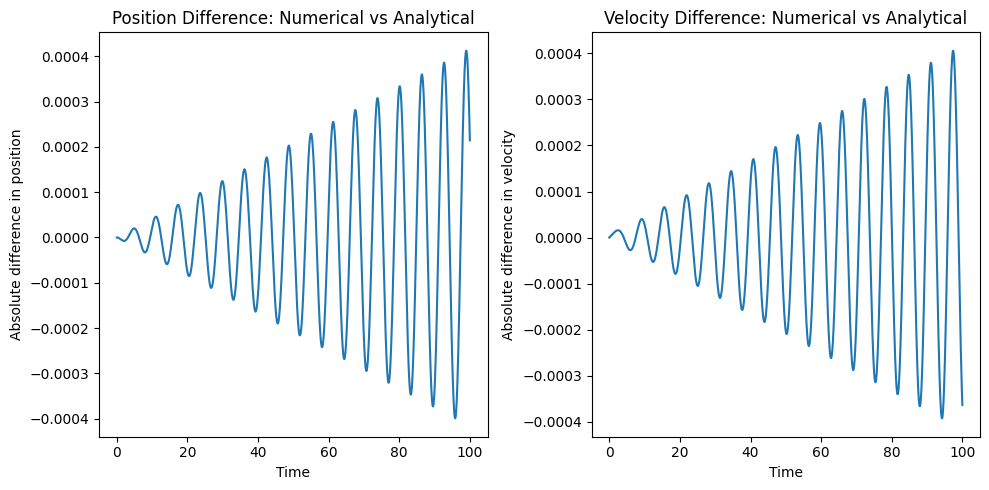

position error = 0.00041235886176956525
velocity error = 0.00040587542295719356


In [ ]:
# Set up the system
k = 1.0  # spring constant
m = 1.0  # mass
oscillator = HarmonicOscillator(k, m)

# Set up the integrator
dt = 0.01  # time step
integrator = VerletIntegrator(dt)

# Initial conditions
x0 = 1.0  # initial position
v0 = 0.0  # initial velocity

# Total simulation time
T = 100.0  # total time

# Compare solutions
times, diff_positions, diff_velocities = compare_solutions(oscillator, integrator, x0, v0, T, dt)

# Plot differences
plot_differences(times, diff_positions, diff_velocities)

print('position error =', max(diff_positions))
print('velocity error =', max(diff_velocities))



Verlet算法的误差主要来自于两个方面：

1. 截断误差：这是由于在Verlet积分公式中，对于物体的加速度，我们只保留了力的二阶泰勒展开，而忽略了高阶项引起的。这种误差通常与时间步长的平方成正比。

2. 舍入误差：这种误差主要是由于计算机在进行浮点运算时引入的。在计算的每一步中，都可能引入微小的舍入误差。然而，由于Verlet算法的递归性，这些小的误差可能会随着时间的推移而累积，从而影响结果的精度。

通常，为了减小这些误差，我们可以选择较小的时间步长，并确保对力的计算尽可能精确。然而，值得注意的是，选择过小的时间步长会导致计算成本增加，并可能增加舍入误差。因此，在实践中，需要找到一个平衡，使得时间步长足够小以提供所需的精度，同时又足够大以避免不必要的计算成本和舍入误差。

我们接下来考察误差随积分步长dt的变化

position errors: [0.00041235886176956525, 0.0016494070156769288, 0.003711495200331783, 0.006598476828849696, 0.01031001643284267, 0.014845671635820295, 0.020210157918352917, 0.02640534074837583]
velocity errors: [0.00040587542295719356, 0.001623465036370706, 0.003652657323419797, 0.0064941845213852024, 0.010146602326600945, 0.014610398993287314, 0.01988914570882578, 0.025979874689841257]


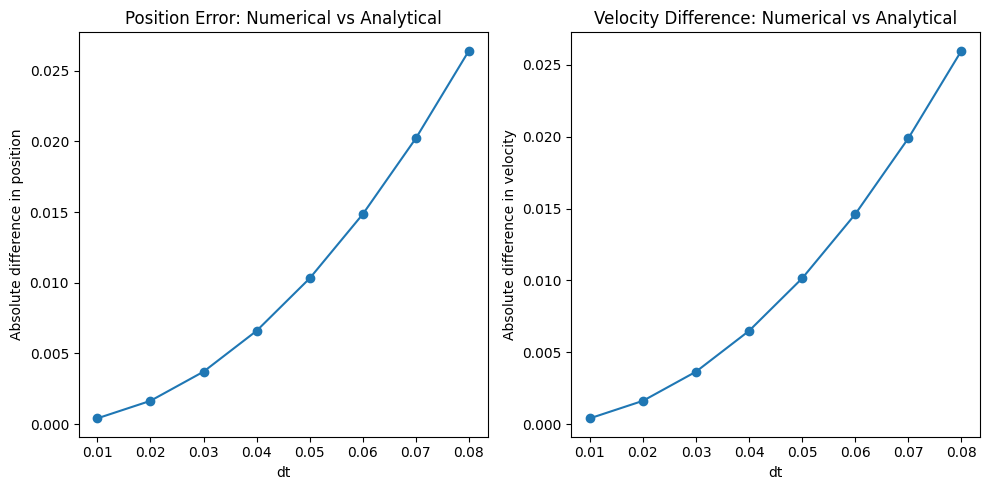

In [ ]:
# Set up the system
k = 1.0  # spring constant
m = 1.0  # mass
oscillator = HarmonicOscillator(k, m)

# Total simulation time
T = 100.0  # total time

stepSize = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
err_pos = []
err_vel = []

# Compare solutions
for dt in stepSize:
    integrator = VerletIntegrator(dt)
    times, diff_positions, diff_velocities = compare_solutions(oscillator, integrator, x0, v0, T, dt)
    err_pos.append(max(diff_positions))
    err_vel.append(max(diff_velocities))

print('position errors:',err_pos)
print('velocity errors:',err_vel)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(stepSize, err_pos,'o-')
plt.xlabel('dt')
plt.ylabel('Absolute difference in position')
plt.title('Position Error: Numerical vs Analytical')

plt.subplot(1, 2, 2)
plt.plot(stepSize, err_vel,'o-')
plt.xlabel('dt')
plt.ylabel('Absolute difference in velocity')
plt.title('Velocity Difference: Numerical vs Analytical')

plt.tight_layout()
plt.show()

我们可以看到，误差的积累随着dt呈抛物线二阶增长。